# Imports
## Author: Mrinmoy Sarkar
## email: mrinmoy.pol@gmail.com, msarkar@aggies.ncat.edu

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from torch import nn


import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback

ModuleNotFoundError: No module named 'tensorflow'

# Data Preprocessing

In [73]:
profile_spec_path = './logs/profiles_eval_sample/'
performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0

file_spec_names = []
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            file_spec_names.append(file)

train_files, test_files = train_test_split(file_spec_names, test_size=0.15)

print(len(train_files), len(test_files))

#create train dataset
for file in train_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1
        
#create test dataset
test_evtol_performance_data_dic = {}
sample_index = 0
for file in test_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            performance_df = pd.read_csv(performance_path)
            performance_df = performance_df.fillna(0)
            outputs.append(performance_df.copy())
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        test_evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 'outputs':outputs}
        sample_index += 1

print(len(evtol_performance_data_dic))
print(len(test_evtol_performance_data_dic))

81 15
80
15


In [74]:
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_weights = {'hover_climb':2, 'dep_transition':2, 'second_climb':2,
       'departure_terminal_procedures':2, 'accel_climb':2, 'cruise':1, 'decel_descend':2,
       'arrival_terminal_procedure':2, 'second_descent':2, 'app_transition':2,
       'hover_descent':2}
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]


In [75]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_datatestX():
    data_X = None
    for key in range(len(test_evtol_performance_data_dic)):
        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_datatestY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_Y

def get_data_for_inference(performance):
    data_X = None
    key = np.random.randint(0, len(test_evtol_performance_data_dic))
    
    X = None
    x = test_evtol_performance_data_dic[key]['input']
    evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
    for i in range(x.shape[0]):
        x_row = x.iloc[i].to_numpy()
        x1 = get_one_hot_encode_evtol(evtol_type)
        x2 = get_one_hot_encode_segment(x_row[0])
        x3 = x_row[1:].astype('float64')
        x_row = np.concatenate((x1,x2,x3))
        X = x_row if X is None else np.vstack((X,x_row))
    data_X = X if data_X is None else np.vstack((data_X, X))
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    Y = None
    y = test_evtol_performance_data_dic[key]['outputs'][indx]
    for i in range(0,y.shape[0],8):
        y_row = y.iloc[i:i+8].to_numpy()
        y_row = y_row[:, 2:].astype('float64')
        y_row = np.mean(y_row, axis=0)
        Y = y_row if Y is None else np.vstack((Y, y_row))
    data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
    return data_X, data_Y

def get_data_for_lstm(performance):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        yield X, Y
        
def get_data_for_lstm_idx(performance, idx):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        
        ii = list(range(x.shape[0]))
        jj = list(range(0,y.shape[0],8))
        ii = ii[0:-1]
        jj = jj[1:]
        
        for i,j in zip(ii,jj):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x4 = y.iloc[i:i+8].to_numpy()
            x4 = x4[:, idx].astype('float64')
            x4 = [np.mean(x4, axis=0)]
            
            x_row = np.concatenate((x1,x2,x3,x4))
            
            y_row = y.iloc[j:j+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            
            X = x_row if X is None else np.vstack((X,x_row))
            Y = y_row if Y is None else np.vstack((Y, y_row))
            
        yield X, Y

In [76]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('flight_conditions')
print(dataY.shape)
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

(5737, 22)
(5737, 6)
(38, 22) (38, 6)


# Test Data Preprocessing Code

0.012308854177404833


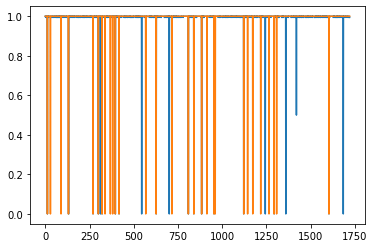

In [77]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.3, random_state=42)
regr_1 = DecisionTreeRegressor(max_depth=32)
regr_1.fit(X_train, y_train[:,5])
y_1 = regr_1.predict(X_test)
plt.plot(y_1)
plt.plot(y_test[:,5])
err1 = mean_squared_error(y_test[:,5],y_1)
print(err1)

# Results Dictionary Definition

In [117]:
criterias_lst = ["MAE", "MSE", "RMSE", "MAPE"]
fesibility_criterias_lst = ['accuracy', 'f1', 'precision', 'recall']
# criterias = {"MAE":{}, "MSE":{}, "RMSE":{}, "MAPE":{}}
performance = {'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}} #criterias}
result = {'DT':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'ADBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'GBoost':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, 
          'RF':{'flight_conditions':{}, #criterias, 
               'aircraft_electronics':{}, #criterias,
               'aerodynamic_coefficients':{}, #criterias, 
               'electric_motor_and_propeller_efficiencies':{}}, }
#           'SVR':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}, 
#           'MLP':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}, 
#           'LSTM':{'flight_conditions':{}, #criterias, 
#                'aircraft_electronics':{}, #criterias,
#                'aerodynamic_coefficients':{}, #criterias, 
#                'electric_motor_and_propeller_efficiencies':{}}}
fesibility_result = {'DT':{'fesibility':{}}, 'ADBoost':{'fesibility':{}}, 
                     'GBoost':{'fesibility':{}}, 'RF':{'fesibility':{}}, }
#                      'SVC':{'fesibility':{}}, 'MLP':{'fesibility':{}}, 'LSTM':{'fesibility':{}}}

# DecisionTreeRegressor

## Flight Conditions

In [118]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = DecisionTreeClassifier(max_depth=32)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.965166908563135


In [119]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
#     print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] != 0.0
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['flight_conditions'][outputs[output_indx]] = {}
    result['DT']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    

# start_time = time.time()
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# print('Inference Time {}s'.format(time.time()-start_time))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.01
0.0
401.72


## Aerodynamic Coefficients

In [120]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()   

0.0
0.0
0.0
0.0


## Aircraft Electronics

In [140]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['aircraft_electronics'][outputs[output_indx]] = {}
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

    
# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()
   

0.03
267.02
0.01
351.99
292.03
55.11
0.19
0.19
0.05


## Electric motor and propeller efficiencies 

In [145]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

    
# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()
   

0.0
0.0
36.81
3.94
33.88
0.0
0.0
0.0
0.17
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# AdaBoostRegressor

## Flight Conditions

In [121]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=300, 
                         random_state=np.random.RandomState(1))
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['ADBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['ADBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['ADBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['ADBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.965166908563135


In [122]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
rng = np.random.RandomState(1)
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for output_indx, i in enumerate([0,1,2,3]): #,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] != 0.0
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['flight_conditions'][outputs[output_indx]] = {}
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        
            
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.01
0.0
270.6


## Aerodynamic Coefficients

In [123]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.0
0.0


## Aircraft Electronics

In [141]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]] = {}
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.02
206.13
0.03
252.25
214.91
60.79
0.14
0.1
0.11


## Electric motor and propeller efficiencies

In [148]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
10.38
29.64
58.2
0.0
0.0
0.0
0.17
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# GradientBoostingRegressor

## Flight Conditions

In [124]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = GradientBoostingClassifier(random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['GBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['GBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['GBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['GBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.965166908563135


In [125]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] != 0.0
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
    

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['flight_conditions'][outputs[output_indx]] = {}
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.02
0.01
251.2


## Aerodynamic Coefficients

In [138]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.02
0.0


## Aircraft Electronics

In [142]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['aircraft_electronics'][outputs[output_indx]] = {}
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.02
167.97
1.47
215.81
186.11
45.13
0.09
0.09
6.11


## Electric motor and propeller efficiencies

In [147]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')


scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = GradientBoostingRegressor(random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = abs(test_Y[:, i]) > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    
    

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
18.13
66.06
43.19
0.0
0.0
0.0
0.22
0.08
0.0
0.0
0.0
0.0
0.0
0.0


# RandomForestRegressor

## Flight Conditions

In [127]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = RandomForestClassifier(max_depth=8, random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['RF']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['RF']['fesibility']['f1'] = round(f1, 2)
fesibility_result['RF']['fesibility']['precision'] = round(precision, 2)
fesibility_result['RF']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.967343976777939


In [128]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['flight_conditions'][outputs[output_indx]] = {}
    result['RF']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


0.0
0.03
0.01
275.48


## Aerodynamic Coefficients

In [129]:
dataX = get_dataX()
dataY = get_dataY('aerodynamic_coefficients')
datatestX = get_datatestX()
datatestY = get_datatestY('aerodynamic_coefficients')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]] = {}
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['aerodynamic_coefficients'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
        

        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
0.01
0.0


## Aircraft Electronics

In [143]:
dataX = get_dataX()
dataY = get_dataY('aircraft_electronics')
datatestX = get_datatestX()
datatestY = get_datatestY('aircraft_electronics')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['aircraft_electronics'][outputs[output_indx]] = {}
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['aircraft_electronics'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.02
176.34
0.09
243.39
202.03
42.08
0.09
0.09
0.37


## Electric motor and propeller efficiencies

In [151]:
dataX = get_dataX()
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
datatestX = get_datatestX()
datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))
    
        

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

0.0
0.0
19.61
120.69
42.51
0.0
0.0
0.0
0.18
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# SVR

## Flight Conditions

In [23]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = svm.SVC()
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['SVC']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['SVC']['fesibility']['f1'] = round(f1, 2)
fesibility_result['SVC']['fesibility']['precision'] = round(precision, 2)
fesibility_result['SVC']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9868804664723032


206638.44
415.51
8.13
326.43
(48, 22) (48, 6)


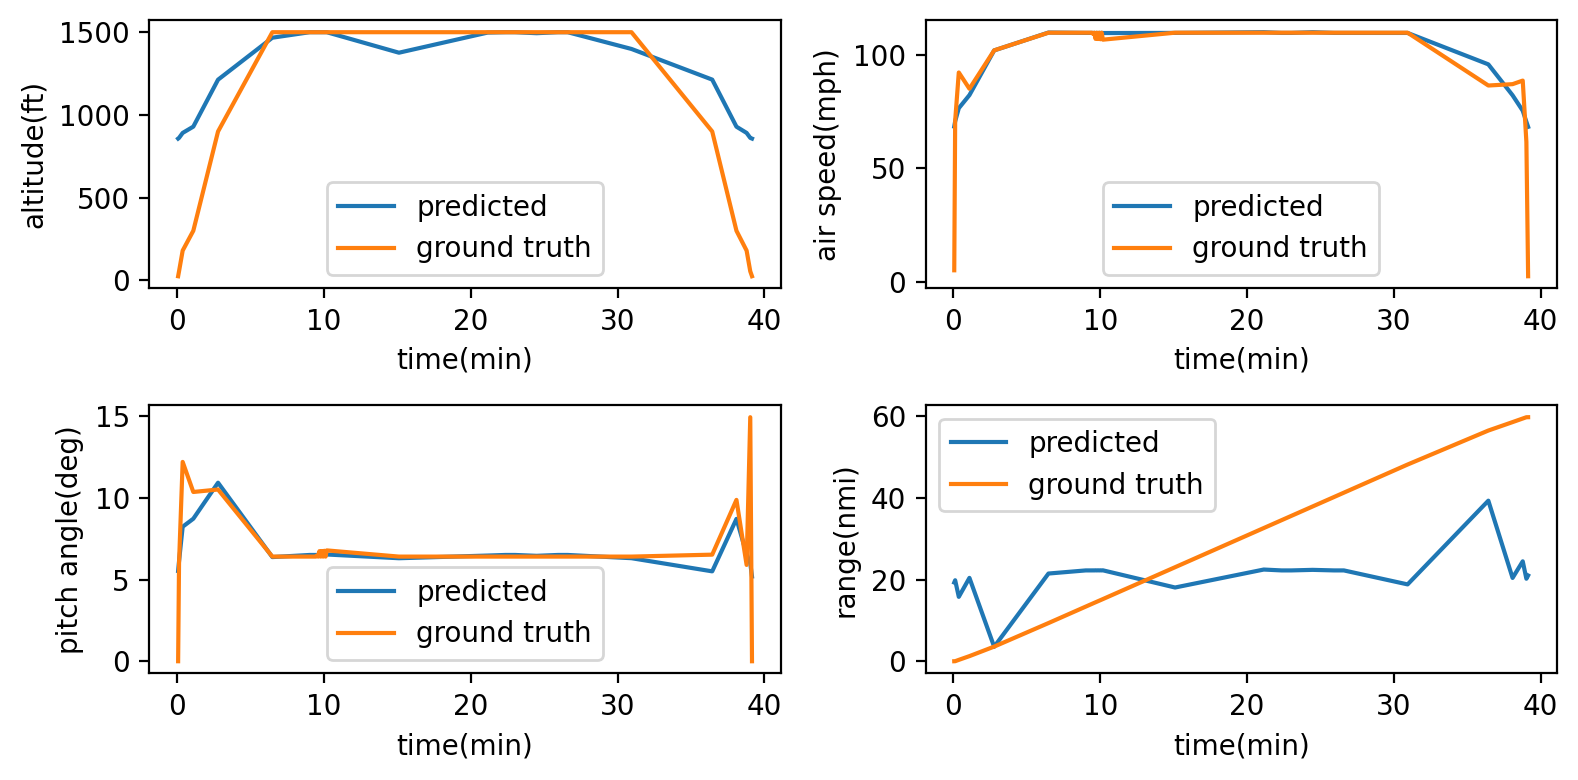

In [25]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    regr = svm.SVR()
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['SVR']['flight_conditions'][outputs[output_indx]] = {}
    result['SVR']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['SVR']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['SVR']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
pred_Y = None
for estimator in best_estimators:
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# MLP

## Flight Conditions

In [26]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,5]
clf = MLPClassifier(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]
acc = accuracy_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
f1 = f1_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
precision = precision_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)
recall = recall_score(datatestY[:,5], clf.predict(datatestX), sample_weight=weights)

fesibility_result['MLP']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['MLP']['fesibility']['f1'] = round(f1, 2)
fesibility_result['MLP']['fesibility']['precision'] = round(precision, 2)
fesibility_result['MLP']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9956268221574344


63044180208.52
159941484.35
530811.63
13297592.15
(29, 22) (29, 6)


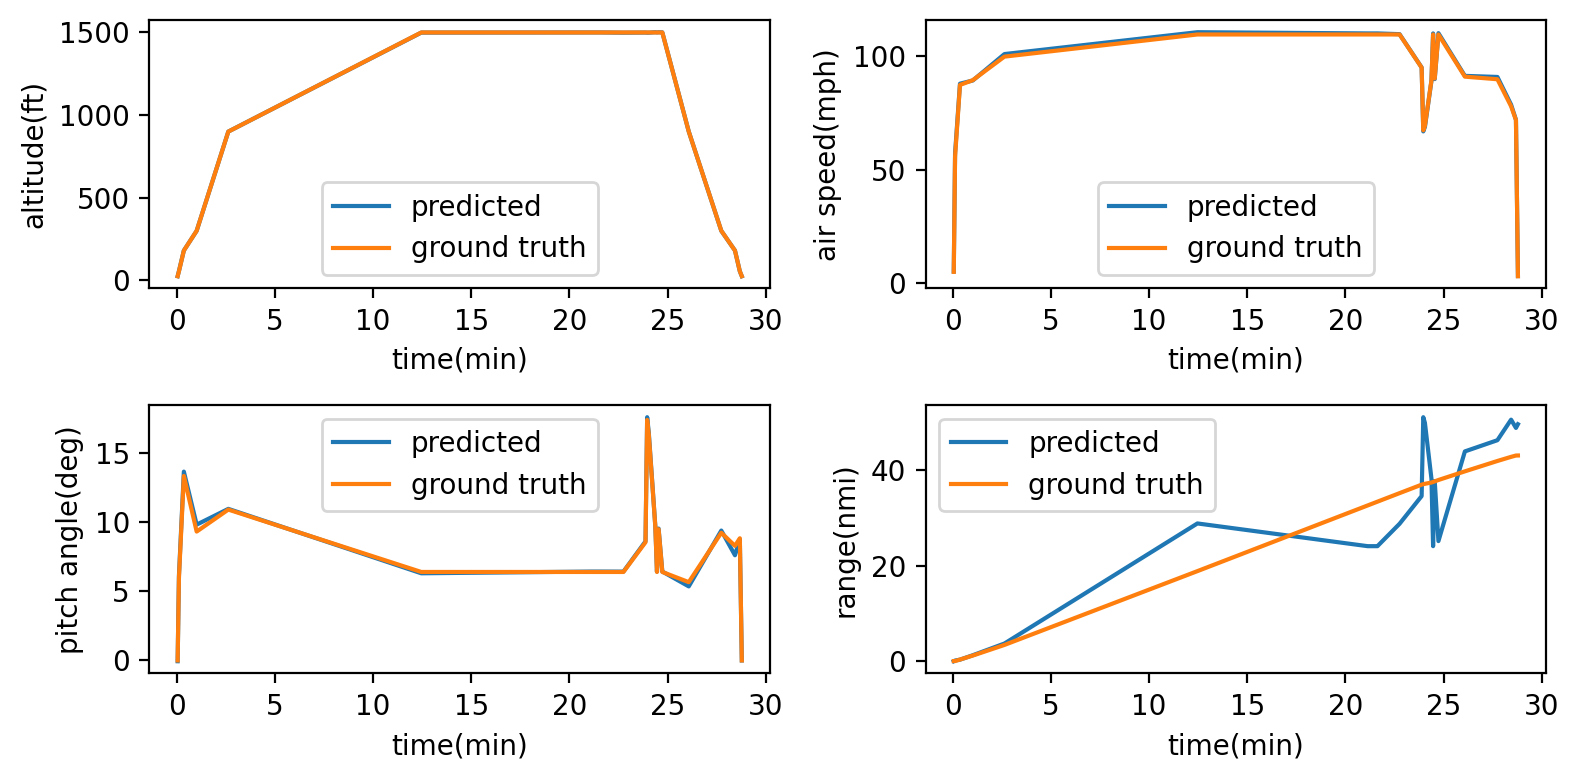

In [27]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
datatestX = get_datatestX()
datatestY = get_datatestY('flight_conditions')

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
    
    regr = scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]
    
    indxes = datatestY[:,-1]==1
    test_X = datatestX[indxes]
    test_Y = datatestY[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    mse = mean_squared_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mae = mean_absolute_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    mape = mean_absolute_percentage_error(test_Y[:,i], regr.predict(test_X), sample_weight=weights)
    
    result['MLP']['flight_conditions'][outputs[output_indx]] = {}
    result['MLP']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['MLP']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['MLP']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(round(mse,2))

testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)

pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(test_X)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

## Aerodynamic Coefficients

(5687, 22)
(5687, 6)
0.0004
0.0002
0.2474
0.0023
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1)]
(256, 22) (256, 6)
(256, 6) (256, 4)


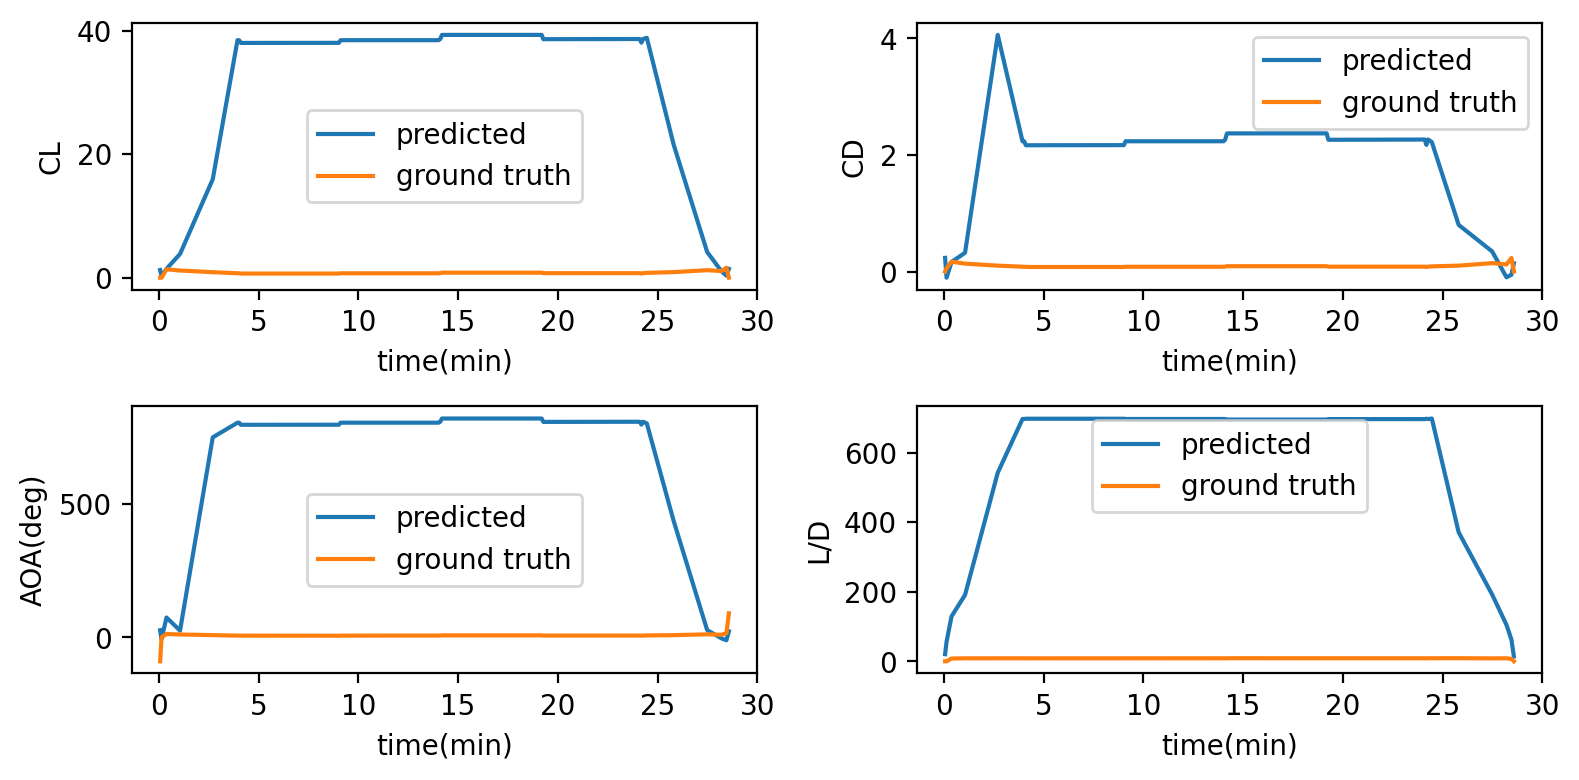

In [113]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aerodynamic_coefficients')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
for output_indx, i in enumerate([0,1,2,3]):#,5]):
    train_X = dataX
    y = dataY[:,i]
    if i!=5:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
        
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['aerodynamic_coefficients']:
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]] = {}
            result['MLP']['aerodynamic_coefficients'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,4]
true_i = [0,1,2,3]#,5]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

## Aircraft Electronics

(5687, 22)
(5687, 11)
0.0141
126.7662
0.1585
161.7594
136.1473
28.1845
0.0579
0.056
3.3224
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1)

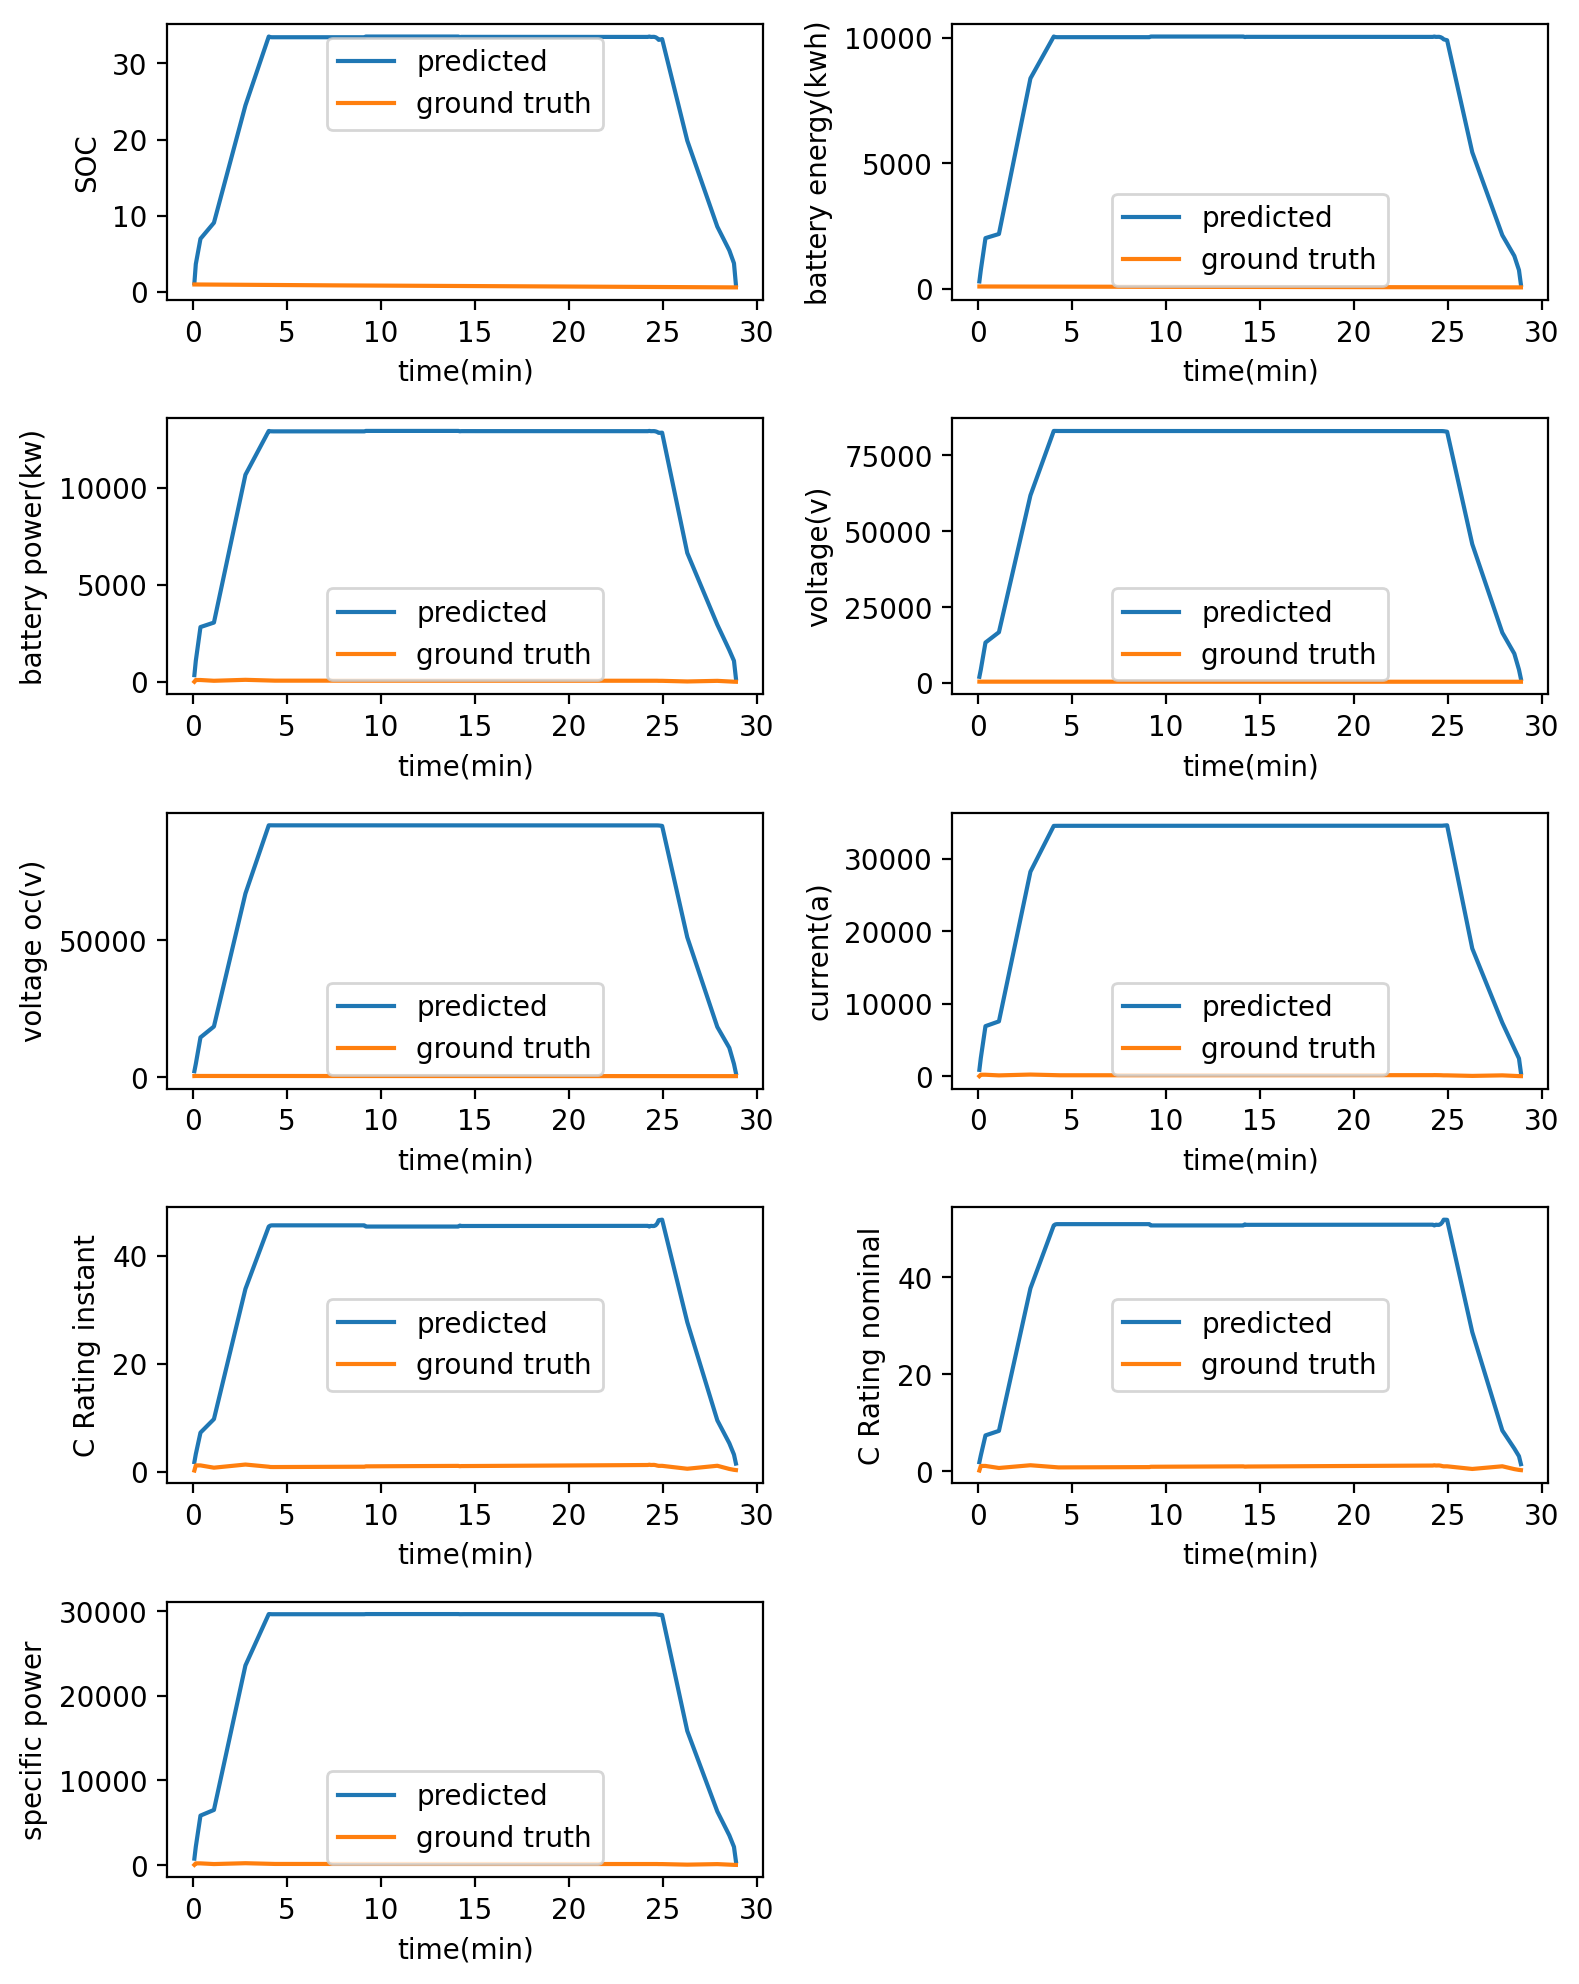

In [114]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('aircraft_electronics')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8]):#,10]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['aircraft_electronics']:
            result['MLP']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['aircraft_electronics'][outputs[output_indx]] = {}
            result['MLP']['aircraft_electronics'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
pred_Y = None
for i, estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,9]
true_i = [0,1,2,3,4,5,6,7,8]#,10]
fig = plt.figure(figsize=(8,10), dpi=200)
for i in range(1,10):
    plt.subplot(5,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

## Electric motor and propeller efficiencies

(5687, 22)
(5687, 18)
0.0009
0.0
61.9267
216.2518
21.3458
0.0001
0.0
0.0
227.8191
364.8297
0.0312
0.0
0.0
0.0
0.0
0.0
[MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max_iter=1000, random_state=1), MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128),
             learning_rate='adaptive', max

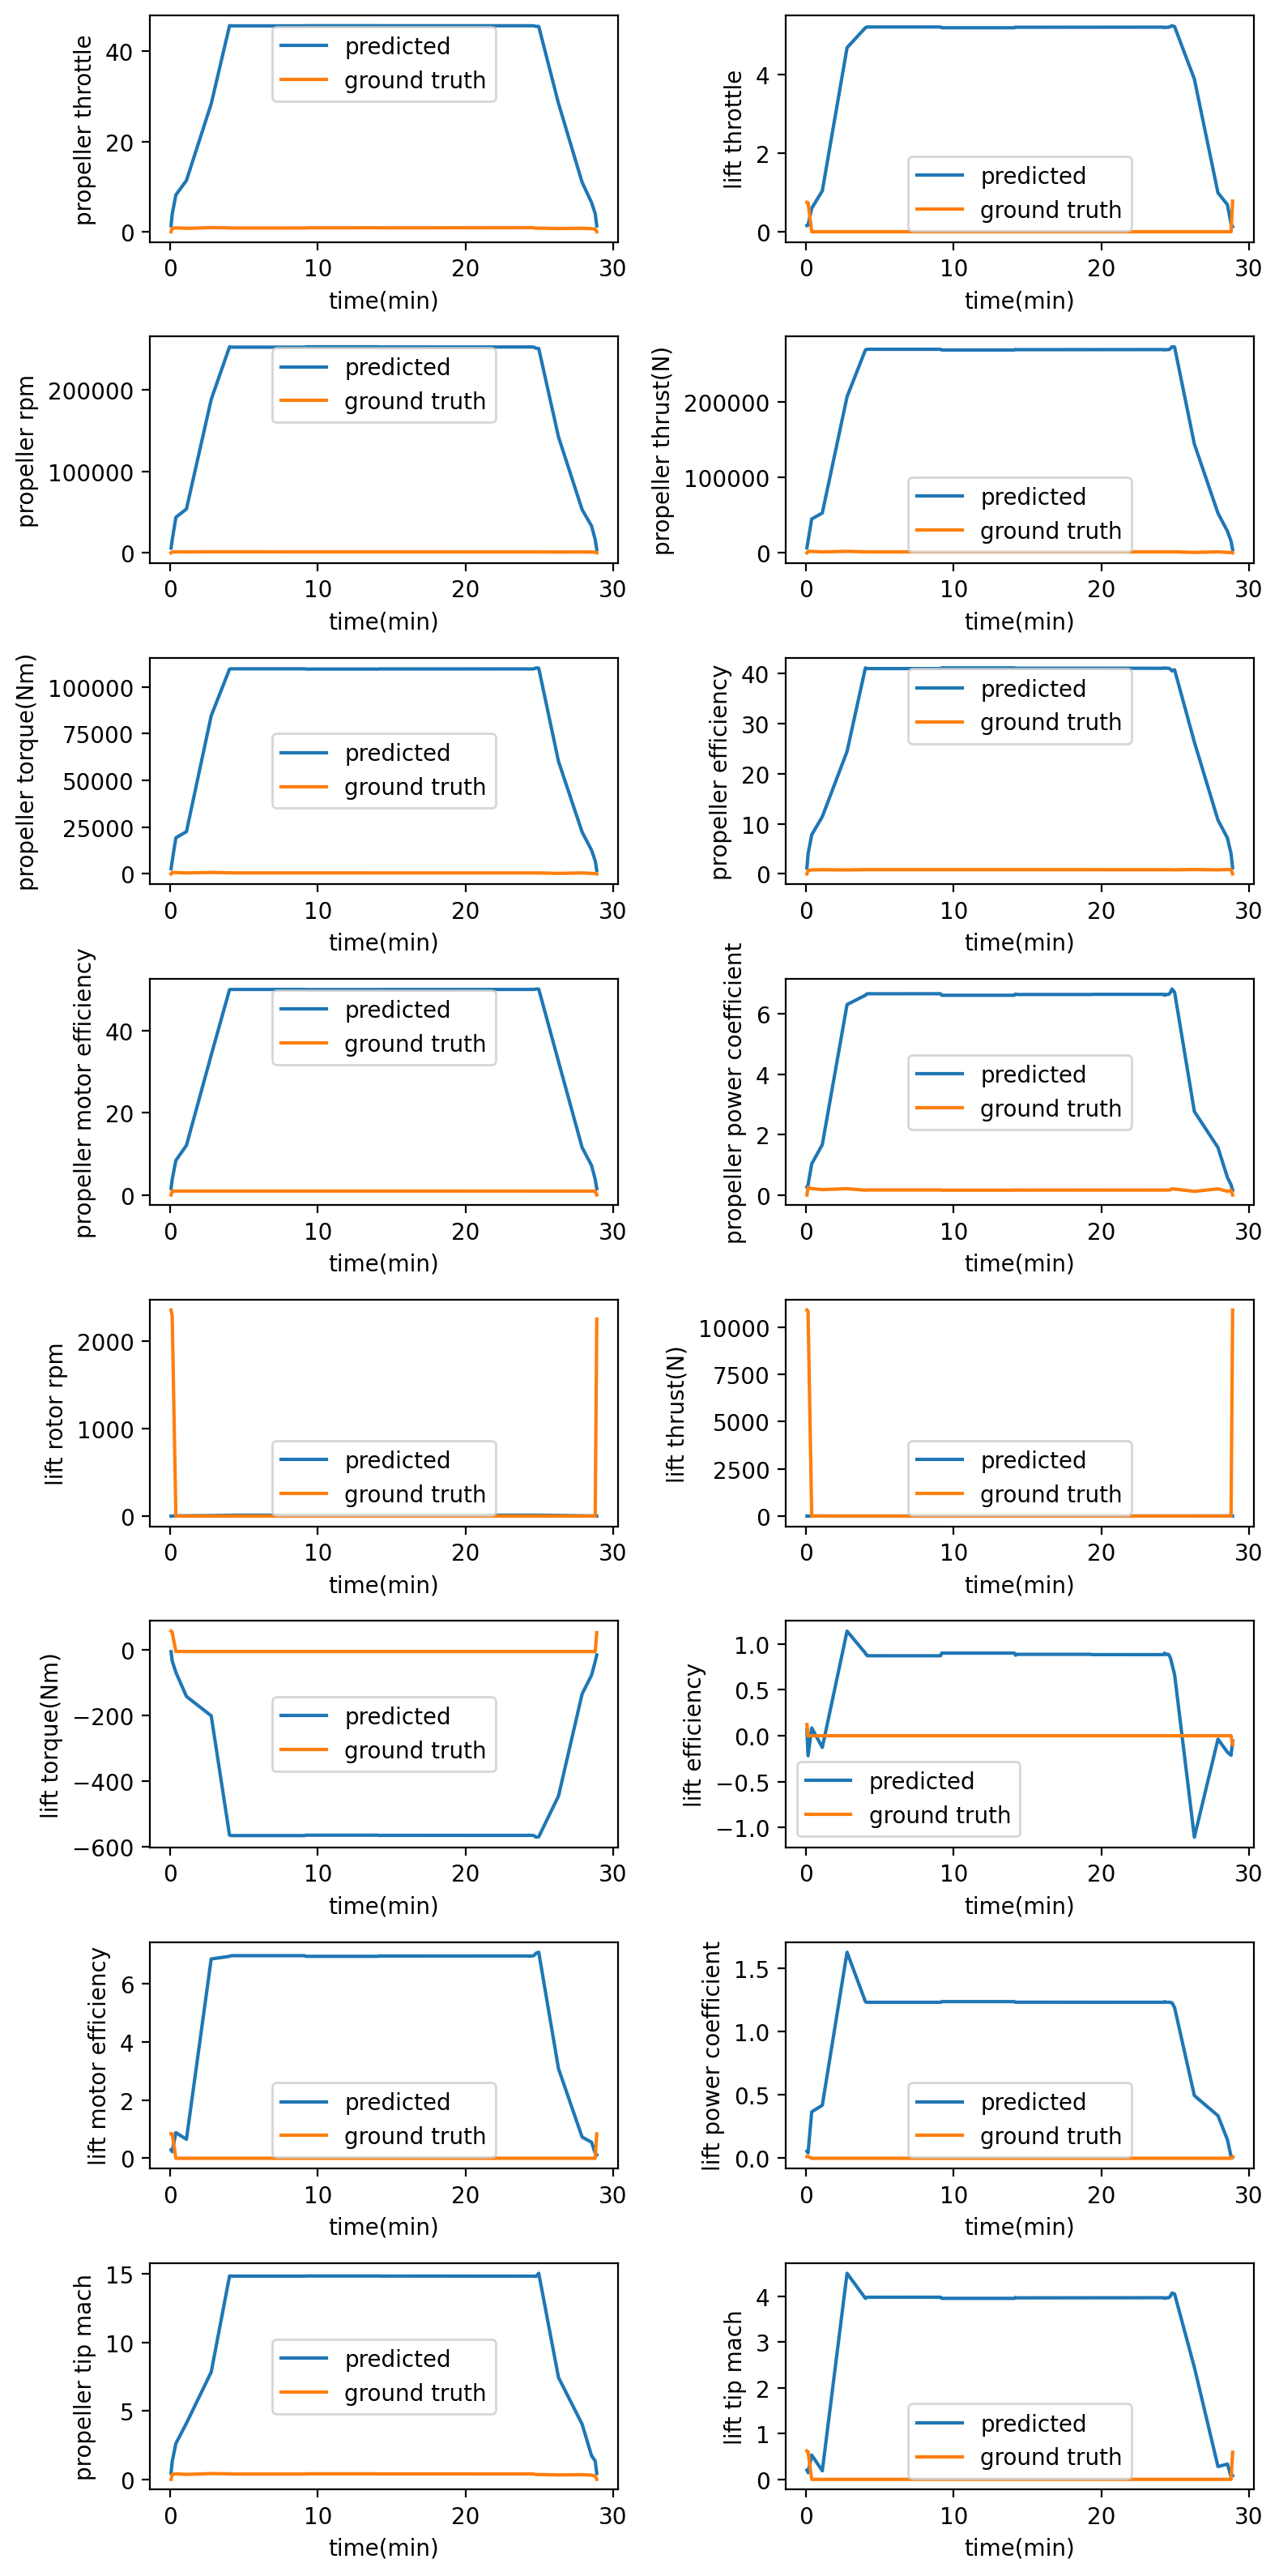

In [115]:
dataX = get_dataX()
print(dataX.shape)
dataY = get_dataY('electric_motor_and_propeller_efficiencies')
print(dataY.shape)

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
scalers = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for output_indx, i in enumerate([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]):#,17]):
    train_X = dataX
    y = dataY[:,i]
    if i!=10:
        indxes = dataY[:,-1]==1
        y = y[indxes]
        train_X = dataX[indxes]
    scaler = StandardScaler() 
    scaler.fit(train_X)  
    train_X = scaler.transform(train_X) 
    scalers.append(scaler)
    regr = MLPRegressor(hidden_layer_sizes=(128, 256, 512, 256, 128, ), 
                        random_state=1, 
                        max_iter=1000, 
                        learning_rate='adaptive',
                        verbose=False)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    print(round(abs(np.mean(scores['test_neg_mean_squared_error'])), 4))
    best_estimators.append(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])])
        
    for j in range(4):
        err = round(abs(np.mean(scores['test_'+scorinngs[j]])), 4)
        if outputs[output_indx] in result['MLP']['electric_motor_and_propeller_efficiencies']:
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
        else:
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]] = {}
            result['MLP']['electric_motor_and_propeller_efficiencies'][outputs[output_indx]][criterias_lst[j]] = err
print(best_estimators)

testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
for i,estimator in enumerate(best_estimators):
    indxes = testY[:,-1]==1
    testY = testY[indxes]
    testX = testX[indxes]
    test_X = scalers[i].transform(testX)
    pred_y = estimator.predict(testX)
#     print(pred_y.shape)
    pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,16]
true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
fig = plt.figure(figsize=(8,16), dpi=200)
for i in range(1,17):
    plt.subplot(8,2,i)
    plt.plot(t, pred_Y[:,i-1], label='predicted')
    plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

# LSTM

## Flight Conditions

In [179]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 64) #fully connected 1
        self.fc = nn.Linear(64, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).float().to(device) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).float().to(device) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
#         hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)
        output = output.view(-1, self.hidden_size)
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

Using cuda device


In [191]:
dataX = get_dataX()
dataY = get_dataY('flight_conditions')
dataX  = np.concatenate((dataX, dataY[:,3].reshape((-1,1))), axis=1) 

mm = StandardScaler() #MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(dataX)
y_mm = mm.fit_transform(dataY[:,3].reshape(-1, 1)) 

num_epochs = 500 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 23 #number of features
hidden_size = 16 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers
seq_length = 1
num_classes = 1 #number of output classes

In [200]:
trainx = dataX[:-5,:]
trainy = dataY[5:,3]
regr = DecisionTreeRegressor(max_depth=64)
scores = cross_validate(regr, train_X, y, cv=5, scoring='neg_mean_squared_error', return_estimator=True)
regr = scores['estimator'][np.argmin(scores['test_score'])]

testX, testY = get_data_for_inference('flight_conditions')
indxes = testY[:,-1]==1
testX = testX[indxes]
testY = testY[indxes]
print(testX.shape, testY.shape)

# X_ss = ss.transform(testX)
# y_mm = mm.transform(testY[:,3].reshape(-1, 1))

y_prev = np.array([[0]])

y_true = []
y_pred = []

for i, x in enumerate(testX):
    x = x.reshape((1,-1))
    x = np.concatenate((x,y_prev), axis=1)
    outputs = regr.predict(x)
    y_true.append(testY[i,3])
    y_pred.append(outputs[0])
    print(y_true[i], y_pred[i])
    y_prev[0,0] = testY[i,3] #outputs[0]

(458, 22) (458, 6)
0.0 0.007816596614873288
0.007814477148487138 0.2935391558954602
0.3039628656441304 1.1832859623705745
1.090213769243734 1.1832859623705745
3.3259868776816397 1.1832859623705745
5.191479211665922 20.54401145365408
5.325902653677176 20.54401145365408
5.458955602045136 20.54401145365408
5.588503914474381 20.54401145365408
5.718051992416987 20.54401145365408
5.847599835422076 20.54401145365408
5.977147443036996 20.54401145365408
6.106694814807309 20.54401145365408
6.236241950276785 20.54401145365408
6.365788848987389 20.54401145365408
6.4953355104792685 20.54401145365408
6.624881934290745 20.54401145365408
6.7544281199583 20.54401145365408
6.883974067016571 20.54401145365408
7.01351977499833 20.54401145365408
7.1430652434344815 20.54401145365408
7.272610471854043 20.54401145365408
7.402155459784144 20.54401145365408
7.531700206750003 20.54401145365408
7.6612447122749225 20.54401145365408
7.790788975880277 20.54401145365408
7.920332997085501 20.54401145365408
8.049876775

In [181]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length) #our lstm class 
lstm1.to(device)
print(lstm1)  

LSTM1(
  (lstm): LSTM(23, 16, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=16, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [182]:
criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
for epoch in range(num_epochs+1):
    err_in_epoch = []
    for X,Y in get_data_for_lstm_idx('flight_conditions',3):
        indxes = Y[:,-1]==1
        y = Y[indxes][:,3]
        train_X = X[indxes]
        X_ss = ss.transform(train_X)
        y_mm = mm.transform(y.reshape(-1, 1)) 
        
        X_train_tensors = torch.tensor(X_ss).float()
        y_train_tensors = torch.tensor(y_mm).float()

        X_train_tensors_final = torch.reshape(X_train_tensors,   
                                              (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        
        X_train_tensors_final = X_train_tensors_final.to(device)
        y_train_tensors = y_train_tensors.to(device)
        outputs = lstm1.forward(X_train_tensors_final) 
        optimizer.zero_grad() 
        loss = criterion(outputs, y_train_tensors)
        loss.backward() 
        optimizer.step()
        err_in_epoch.append(loss.item())
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, np.mean(err_in_epoch))) 

Epoch: 0, loss: 1.45838
Epoch: 100, loss: 0.64705
Epoch: 200, loss: 0.62851
Epoch: 300, loss: 0.61672
Epoch: 400, loss: 0.60942
Epoch: 500, loss: 0.60804


In [183]:
# mm.inverse_transform([[0.40722]])
lstm1.eval()

LSTM1(
  (lstm): LSTM(23, 16, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=16, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [189]:
testX, testY = get_data_for_inference('flight_conditions')
indxes = testY[:,-1]==1
testX = testX[indxes]
testY = testY[indxes]
print(testX.shape, testY.shape)

# X_ss = ss.transform(testX)
# y_mm = mm.transform(testY[:,3].reshape(-1, 1))

y_prev = np.array([[0]])

y_true = []
y_pred = []

for i, x in enumerate(testX):
    x = x.reshape((1,-1))
    x = np.concatenate((x,y_prev), axis=1)
    x_ss = ss.transform(x)
    x_test_tensor = torch.tensor(x_ss).float().to(device)
    x_test = torch.reshape(x_test_tensor, (x_test_tensor.shape[0], 1, x_test_tensor.shape[1]))
    outputs = lstm1.forward(x_test)
    y_true.append(mm.transform([[testY[i,3]]])[0][0])
    y_pred.append(outputs.item())
    print(y_true[i], y_pred[i])
    y_prev[0,0] = outputs.item()


# y_true = testY[:,3]

# X_train_tensors = torch.tensor(X_ss).float()
# y_train_tensors = torch.tensor(y_mm).float()

# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# outputs = lstm1.forward(X_train_tensors_final) 
# outputs = outputs.data.numpy()
# y_pred = mm.inverse_transform(outputs).squeeze()
# print(y_pred.shape)
# print(y_true.shape)
# plt.plot(y_pred)
# plt.plot(y_true)
# print(mean_squared_error(y_true,y_pred))
# print(mean_squared_error(y_mm.squeeze(), outputs.squeeze()))

# pred_Y = None
# for i,estimator in enumerate(best_estimators):
#     test_X = scalers[i].transform(testX)
#     pred_y = estimator.predict(test_X)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

(251, 22) (251, 6)
-1.589566067721908 -1.5927846431732178
-1.5890559520937204 -1.5431036949157715
-1.5710050532102728 -1.4910436868667603
-1.518601191736332 -1.3535953760147095
-1.374719788092331 -1.2863882780075073
-1.2557646552648087 -1.2921066284179688
-1.2469172250666947 -1.4504507780075073
-1.2377822882581047 -1.4905420541763306
-1.2285689206104335 -1.4904968738555908
-1.2193557493179068 -1.490451693534851
-1.2101427753523308 -1.4904059171676636
-1.2009299996945808 -1.4903603792190552
-1.1917174233347247 -1.490314245223999
-1.1825050472721512 -1.4902682304382324
-1.1732928725156988 -1.4902219772338867
-1.164080900083787 -1.4901751279830933
-1.154869131004552 -1.4901280403137207
-1.145657566315982 -1.4900810718536377
-1.1364462070660575 -1.4900333881378174
-1.127235054312893 -1.4899855852127075
-1.1180241091248804 -1.4899379014968872
-1.1088133725808385 -1.4898895025253296
-1.099602845770161 -1.4898412227630615
-1.0903925297929717 -1.4897922277450562
-1.0811824257602773 -1.48974323

In [ ]:
%%time

# training

# deep LSTM model
time_step = 1
num_feature = 23
num_class = 1
direction = 1
neuron_size = 64
lstm_layers = 1


# create model
x_in = Input(shape=(time_step,num_feature),dtype="float32")
bid_layer1 = Bidirectional(LSTM(neuron_size))(x_in)
y = Dense(units=num_class, activation='softmax')(bid_layer1)

model = Model(inputs=x_in, outputs=y)
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['CategoricalAccuracy'])


            # load dataset
            pwd = os.getcwd()
            model_path = pwd+'/models/'

            batch_print_callback = LambdaCallback(on_batch_end=lambda batch,logs: print(batch, logs))

            pwd = os.getcwd()
            database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
            database_file_names = []
            for root, dirs, files in os.walk(database_path):
                database_file_names = [os.path.join(root,file) for file in files]

            scaler = MinMaxScaler()
            encoder = OneHotEncoder()
            train_set = database_file_names[:-1]
            #training loop
            for model_no in range(1,71):
                for i,file in enumerate(train_set):
                    data = pd.read_csv(file)
                    if num_feature == 7:
                        X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
                    else:
                        X_train = data.drop(columns=['label', 'time','pitch_v','roll_v','yaw_v'])

                    X_train = X_train.values
                    Y_train = data['label'].values
                    Y_train = Y_train.reshape((-1,1))
                    if i == 0:
                        X_train = scaler.fit_transform(X_train)
                        Y_train = encoder.fit_transform(Y_train).toarray()
                    else:
                        X_train = scaler.transform(X_train)
                        Y_train = encoder.transform(Y_train).toarray()

                    input_data = X_train[:-time_step,:]
                    targets = Y_train[time_step:,:]
                    dataset = timeseries_dataset_from_array(input_data, 
                                                            targets, 
                                                            sequence_length=time_step,
                                                            batch_size=128)
                    hist = model.fit(dataset,
                                     epochs=10,
                                     verbose=2,
                                     callbacks=None,#[batch_print_callback],
                                     max_queue_size=512,
                                     workers=80,
                                     use_multiprocessing=True)

# show results

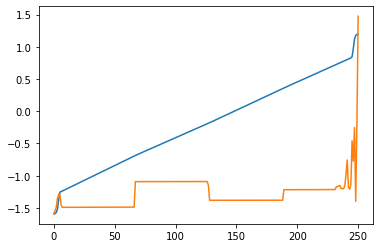

In [190]:
plt.plot(y_true)
plt.plot(y_pred)

# Feasibility Classifier Scores

In [107]:
for key in fesibility_result:
    fes_rslt_df = pd.DataFrame.from_dict(fesibility_result[key])
    print('**********')
    print(key)
    print(fes_rslt_df)

**********
DT
           fesibility
accuracy         0.97
f1               0.98
precision        0.97
recall           1.00
**********
ADBoost
           fesibility
accuracy         0.97
f1               0.98
precision        0.97
recall           1.00
**********
GBoost
           fesibility
accuracy         0.97
f1               0.98
precision        0.97
recall           1.00
**********
RF
           fesibility
accuracy         0.97
f1               0.98
precision        0.97
recall           1.00
**********
SVC
Empty DataFrame
Columns: [fesibility]
Index: []
**********
MLP
Empty DataFrame
Columns: [fesibility]
Index: []
**********
LSTM
Empty DataFrame
Columns: [fesibility]
Index: []


# Regressor Scores

## Flight Conditions

In [130]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['flight_conditions'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.00      401.72
MAE            0.0            0.04              0.01       14.41
MAPE           0.0            0.00              0.00        0.64
**********
ADBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.00      270.60
MAE            0.0            0.05              0.02       11.76
MAPE           0.0            0.00              0.00        0.61
**********
GBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.00            0.02              0.01      251.20
MAE           0.01            0.09              0.05       11.40
MAPE          0.00            0.00              0.01        5.33
**********
RF
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.03              0.01      275.48
MAE            0.0       

## Aerodynamic Coefficients 

In [139]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aerodynamic_coefficients'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.01  0.0
MAPE  0.0  0.0      0.02  0.0
**********
ADBoost
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.03  0.0
MAPE  0.0  0.0      0.02  0.0
**********
GBoost
       CL   CD  AOA(deg)   L/D
MSE   0.0  0.0      0.02  0.00
MAE   0.0  0.0      0.05  0.01
MAPE  0.0  0.0      0.01  0.00
**********
RF
       CL   CD  AOA(deg)   L/D
MSE   0.0  0.0      0.01  0.00
MAE   0.0  0.0      0.06  0.01
MAPE  0.0  0.0      0.02  0.00


## Aircraft Electronics 

In [144]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aircraft_electronics'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  voltage oc(v)  \
MSE   0.03               267.02               0.01      351.99         292.03   
MAE   0.12                11.65               0.05       13.30          12.15   
MAPE  0.20                 0.20               0.00        0.03           0.03   

      current(a)  C Rating instant  C Rating nominal  specific power  
MSE        55.11              0.19              0.19            0.05  
MAE         5.02              0.25              0.25            0.10  
MAPE        0.03              0.21              0.22            0.00  
**********
ADBoost
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  voltage oc(v)  \
MSE   0.02               206.13               0.03      252.25         214.91   
MAE   0.11                10.66               0.10       11.40          10.50   
MAPE  0.18                 0.18               0.00        0.03           0.02   

      current(a)  C Rating instan

##  Electric motor and propeller efficiencies

In [152]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['electric_motor_and_propeller_efficiencies'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      propeller throttle  lift throttle  propeller rpm  propeller thrust(N)  \
MSE                 0.00           0.00          36.81                 3.94   
MAE                 0.03           0.01           1.06                 0.56   
MAPE                0.03           0.01           0.00                 0.00   

      propeller torque(Nm)  propeller efficiency  propeller motor efficiency  \
MSE                  33.88                   0.0                         0.0   
MAE                   0.88                   0.0                         0.0   
MAPE                  0.00                   0.0                         0.0   

      propeller power coefficient  lift rotor rpm  lift thrust(N)  \
MSE                           0.0            0.17             0.0   
MAE                           0.0            0.18             0.0   
MAPE                          0.0            0.00             0.0   

      lift torque(Nm)  lift efficiency  lift motor efficiency  \
MSE   

# test

In [42]:
for X, Y in get_data_for_lstm_idx('flight_conditions',5):
# for X, Y in get_data_for_lstm('flight_conditions'):
    print(X.shape, Y.shape)
    
    if True:
        break

(147, 23) (147, 6)
